In [2]:
%matplotlib inline
import numpy as np
from numpy import mean,cov,cumsum,dot,linalg,size,flipud
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import time
import math as math
import seaborn as sns
sns.set()

# NetworkX and Higher Order Graph Clustering in C. Elegans Neuronal Network

- The neural network of C. Elegans has been completely mapped

b'Skipping line 2: expected 4 fields, saw 15\nSkipping line 3: expected 4 fields, saw 5\n'


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


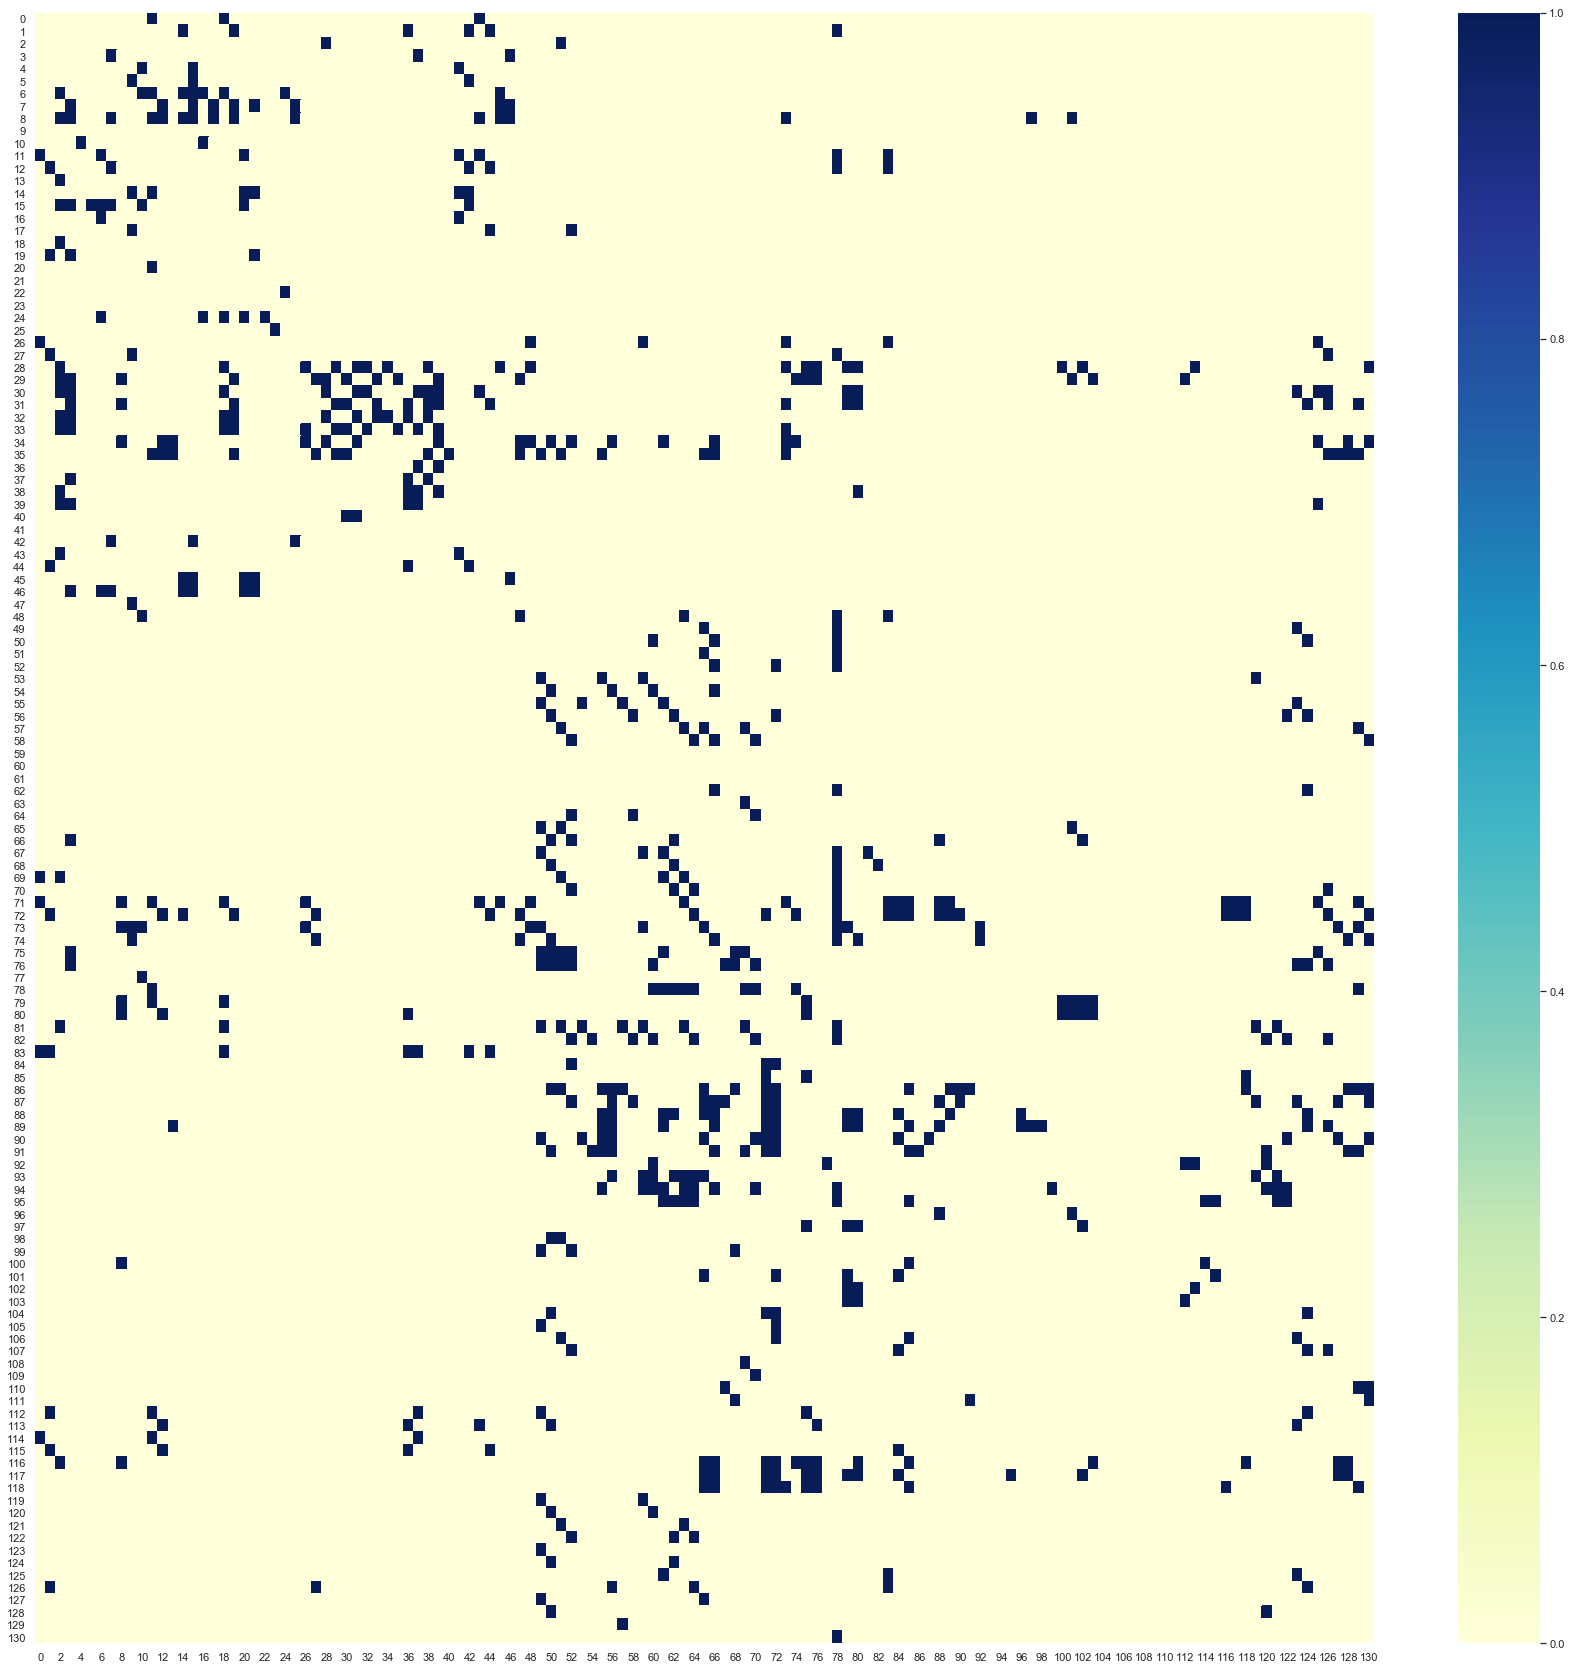

In [31]:
celegans_data = pd.read_csv('C-elegans-frontal.txt', sep=" ", header=None, error_bad_lines=False)

# Pre-synaptic neuron IDs
start = np.array(pd.to_numeric(celegans_data.iloc[2:, 0]))
# Post-synaptic neuron IDs
end = np.array(pd.to_numeric(celegans_data.iloc[2:, 1]))

# number of nodes
num_neurons = max(start)
# number of directed edges
num_synapses = len(start)

# Adjacency matrix of graph with weighted values corresponding to number of edges
# In this case should all be equal to 1
weighted_graph_arr = np.zeros((num_neurons + 1, num_neurons + 1))
for i in range(num_synapses):
    start_id = start[i]
    end_id = end[i]
    weighted_graph_arr[start_id][end_id] += 1
print(weighted_graph_arr)


ax = sns.heatmap(weighted_graph_arr, cmap="YlGnBu")
plt.show()

In [39]:
def binarize(weighted_graph):
    weighted_graph[weighted_graph > 0] = 1
    weighted_graph[weighted_graph <= 0] = 0
    return weighted_graph

unweighted_dir_arr = binarize(weighted_graph_arr)
print(np.where(np.sum(unweighted_dir_arr, axis = 0) == 0))
print(np.where(np.sum(unweighted_dir_arr, axis = 1) == 0))

# print(np.sum(unweighted_dir_arr))

(array([ 93,  94, 104, 105, 106, 107, 108, 109, 110, 111]),)
(array([ 9, 21, 23, 41, 59, 60, 61]),)


NetworkX and matplotlib allow for directed and undirected graph visualization, as demonstrated below.

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


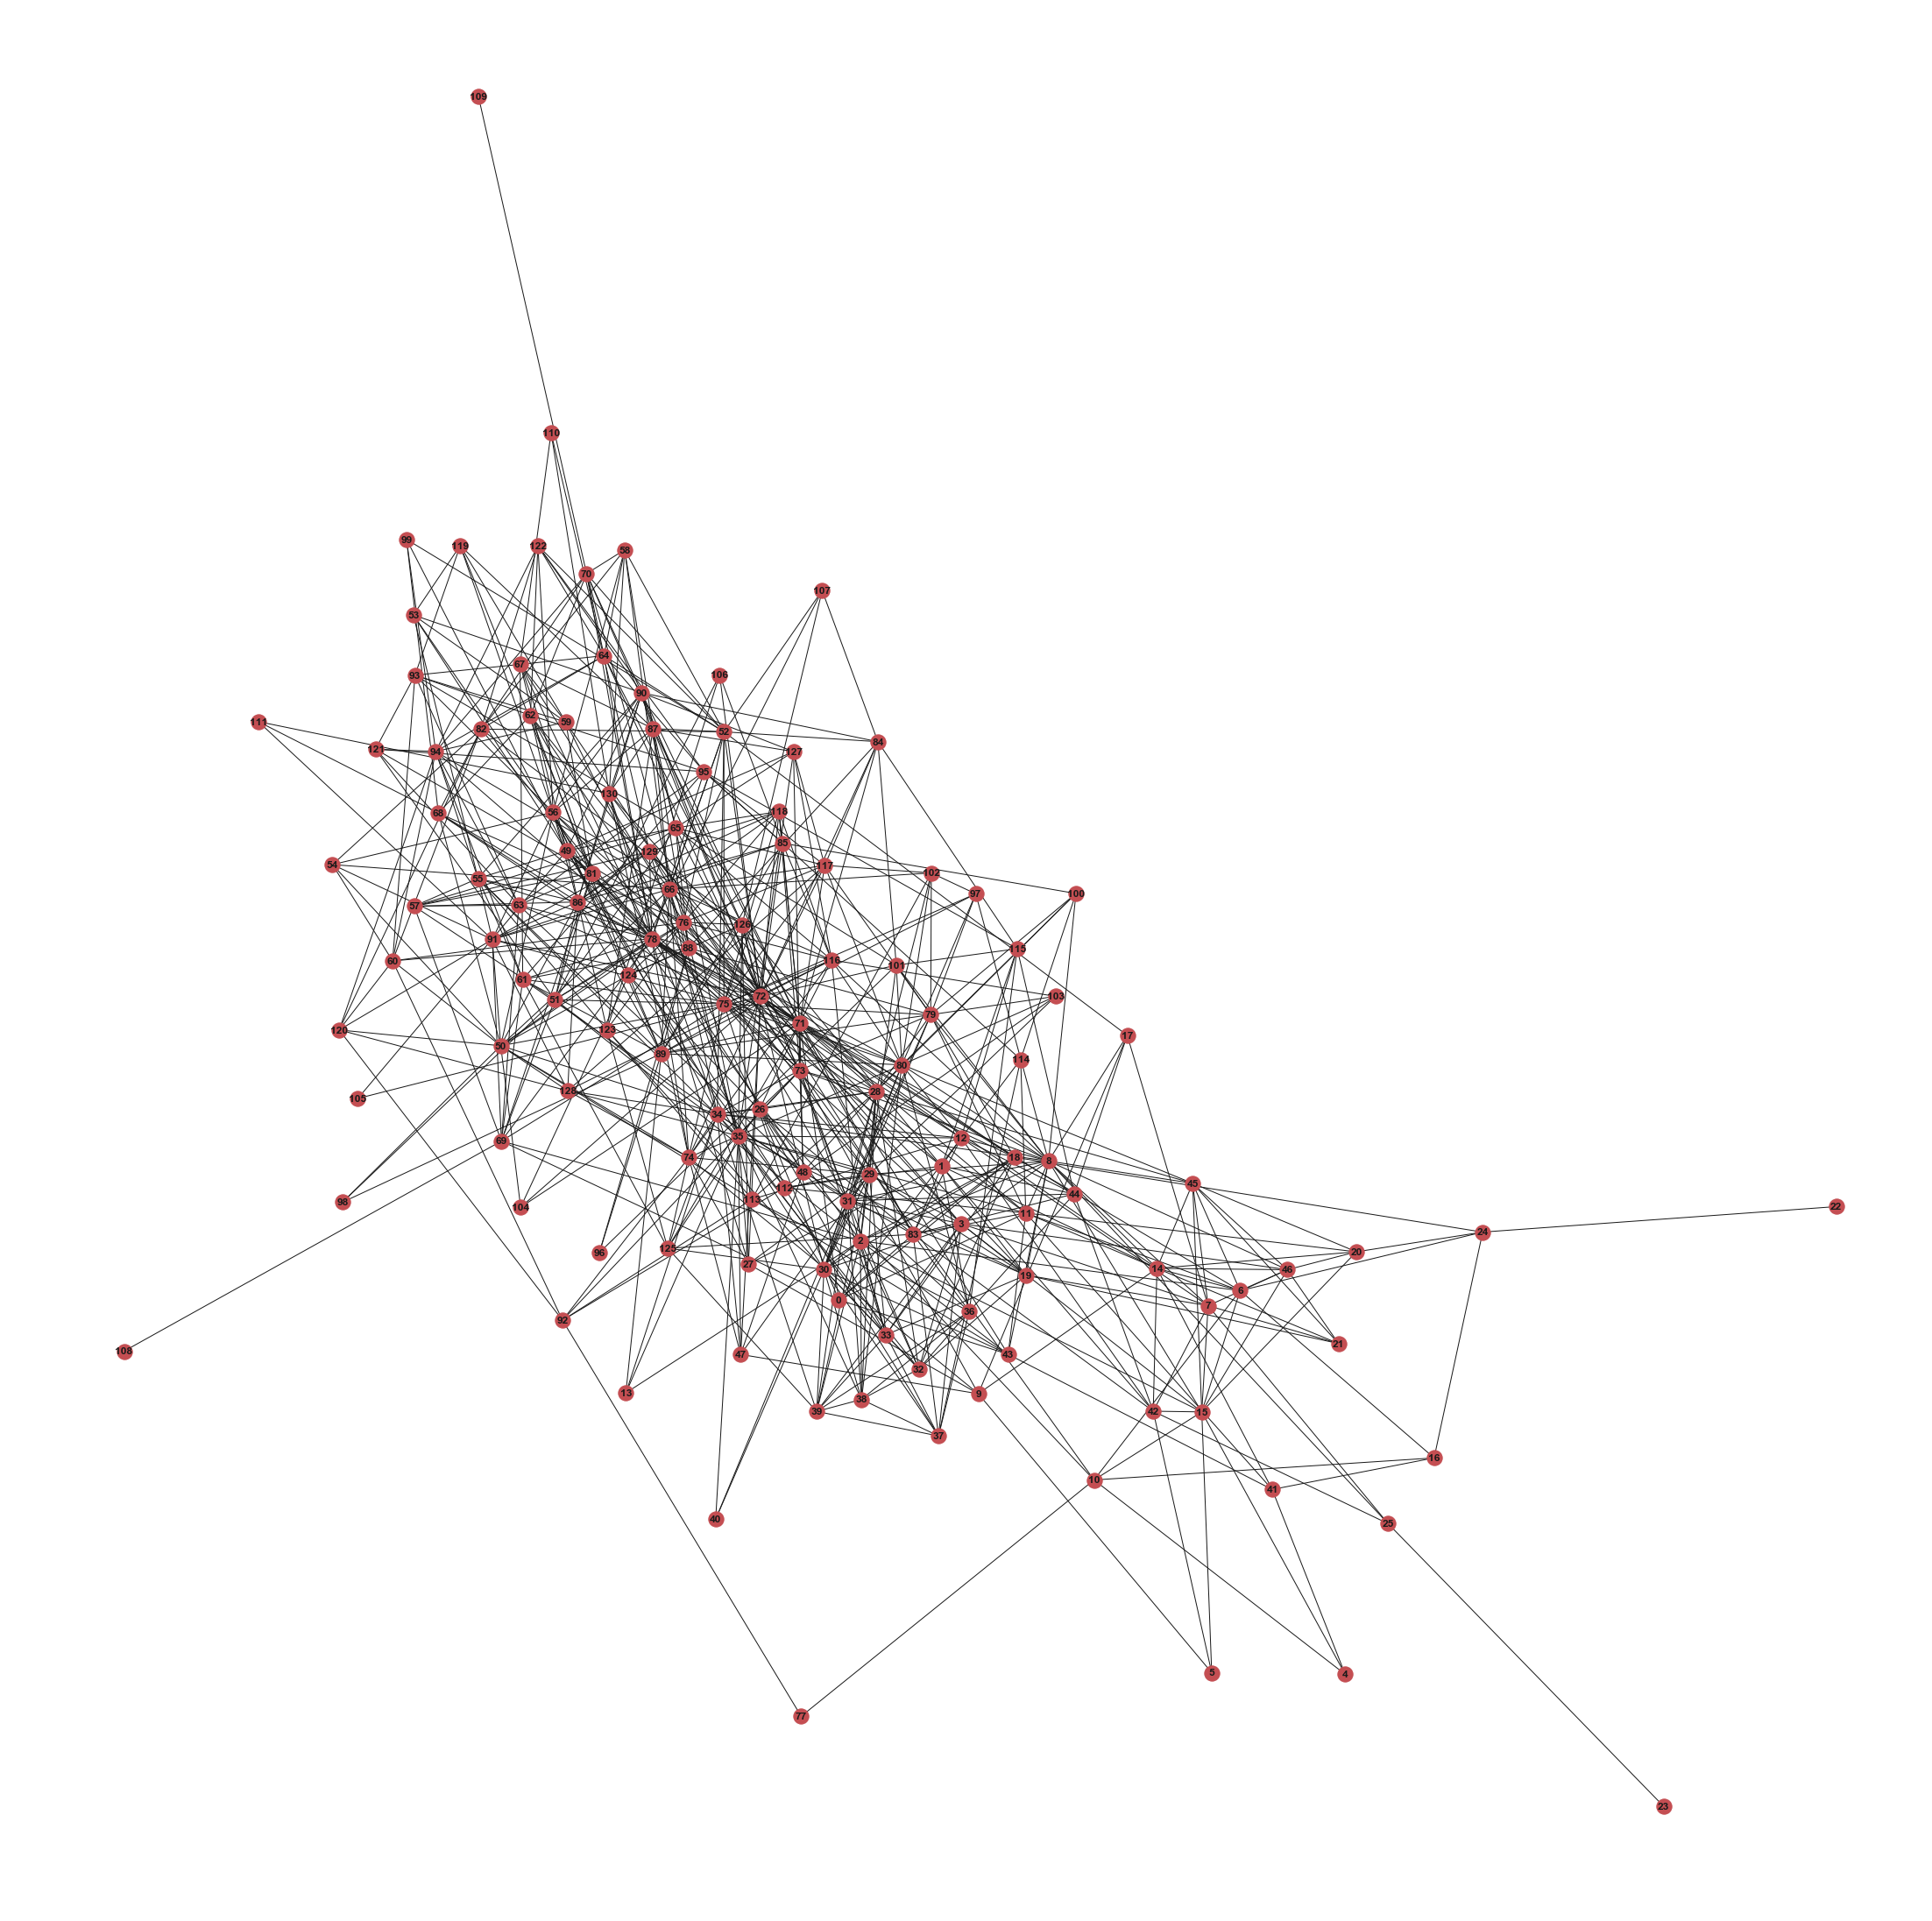

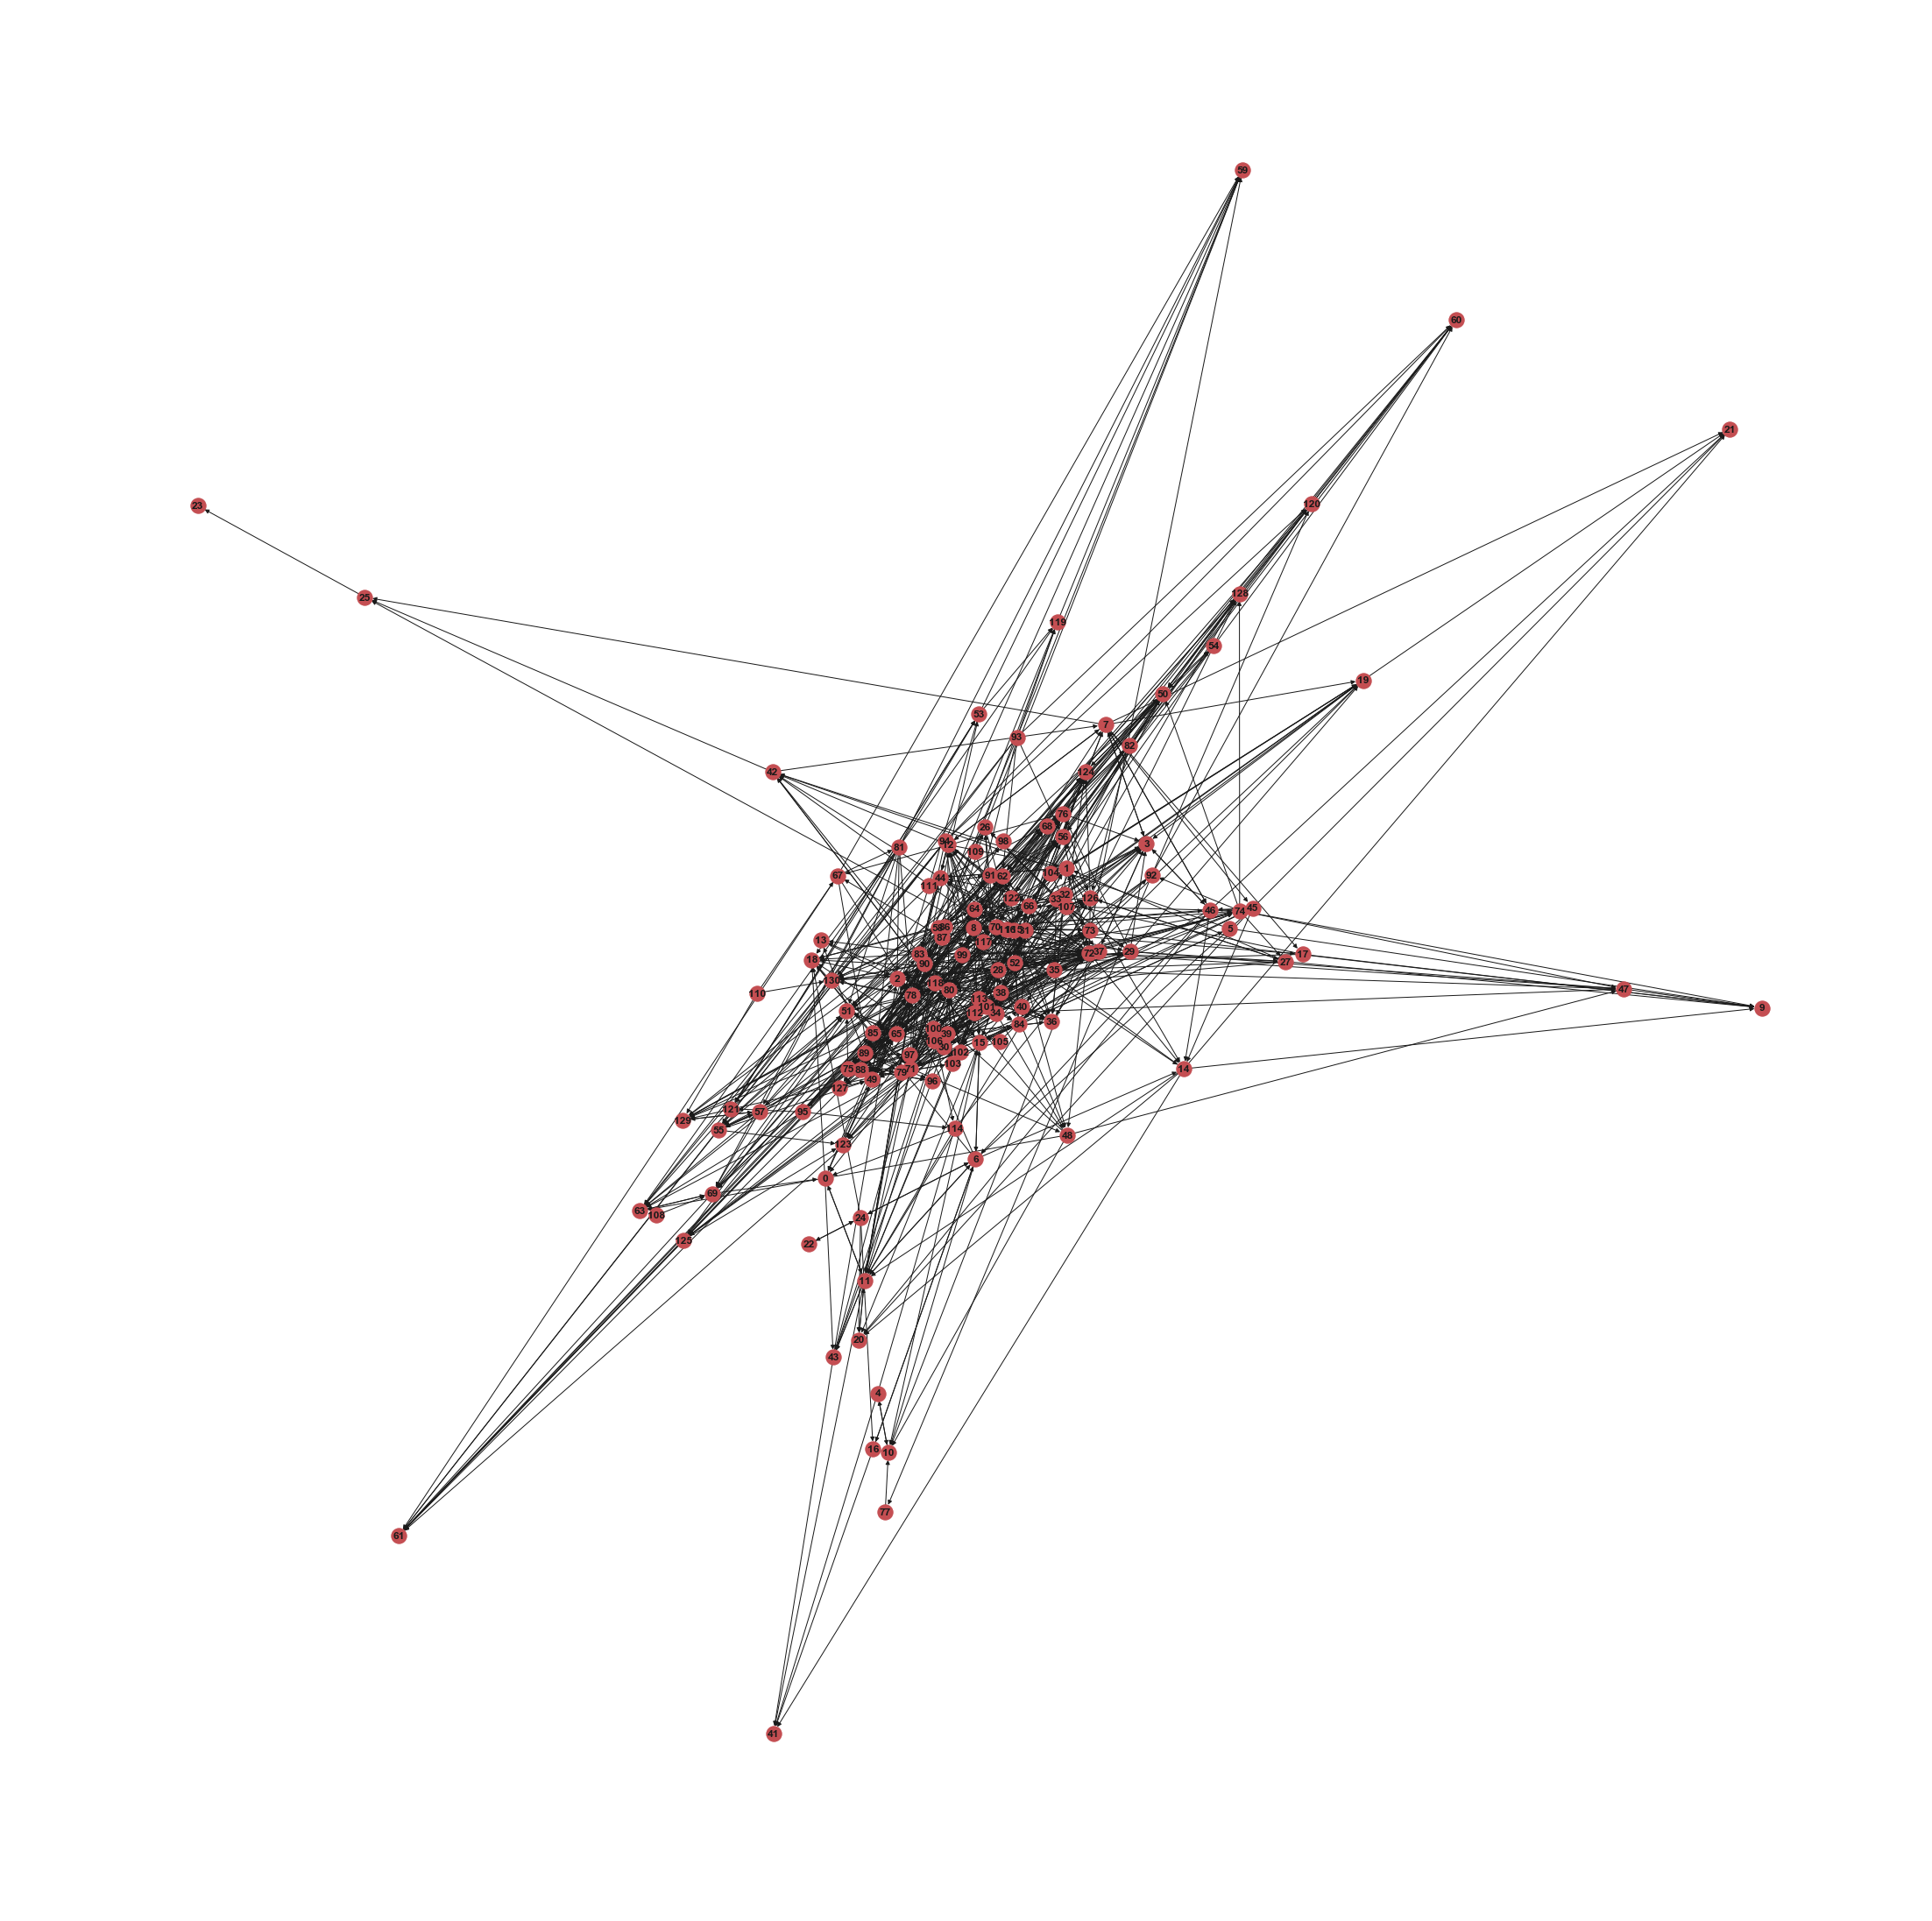

In [27]:
# 1. use networkx to create unweighted directed graph
# 2. use networkx to create weighted directed graph


# creates unweighted directed graph object
def create_graph_uw(unw_dir_arr):
    unweighted_dir_graph = nx.DiGraph()
    n_station = unw_dir_arr.shape[0]
    for i in range(n_station):
        for j in range(n_station):
            if(unw_dir_arr[i][j] == 1):
                unweighted_dir_graph.add_edge(i,j)
    return unweighted_dir_graph

unweighted_dir_graph_1 = create_graph_uw(unweighted_dir_arr)
# nx.draw_circular(unweighted_dir_graph_1, with_labels = True)

def create_graph_w(w_dir_arr):
    weighted_dir_graph = nx.DiGraph()
    n_station = w_dir_arr.shape[0]
    for i in range(n_station):
        for j in range(n_station):
            if(w_dir_arr[i][j] > 0):
                weighted_dir_graph.add_edge(i,j,w_dir_arr[i][j])
    return weighted_dir_graph

plt.rcParams["figure.figsize"] = (30,30)
# nx.clustering(unweighted_dir_graph_1)
for C in nx.connected_component_subgraphs(unweighted_dir_graph_1.to_undirected()):
    nx.draw(C, with_labels=True, font_weight='bold')
    plt.show()
    
nx.draw(unweighted_dir_graph_1, with_labels = True, font_weight = 'bold')
plt.show()

In [6]:
# for C in nx.connected_component_subgraphs(unweighted_dir_graph_1.to_undirected()):
#     print(nx.average_clustering(C))
    
# for C in nx.connected_component_subgraphs(unweighted_dir_graph_1.to_undirected()):
#     print(nx.average_shortest_path_length(C))

unweighted_undir_graph_1 = unweighted_dir_graph_1.to_undirected()
largest_cc = unweighted_undir_graph_1.subgraph(max(nx.connected_components(unweighted_undir_graph_1), key=len))


Small-world networks were first introduced by Watts and Strogatz in 1998
- Lie between the ordered lattices and unordered random graphs
- Are highly clustered like lattices and have short path lengths like random graphs
- Small-world phenomenon: $L \gtrapprox L_{random}$, but $C \gg C_{random}$
- C. Elegans neural network exhibits small-world property, as shown in Watts and Strogatz (1998)
- Suggested measures of small-world property:
    - $\sigma = \dfrac{\dfrac{C}{C_{rand}}}{\dfrac{L}{L_{rand}}}$
    - $\omega = \dfrac{L_{rand}}{L} - \dfrac{C}{C_{latt}}$ is a more accurate measurement of the small-world property of a network compared to $\sigma$ according to Telesford, Joyce 2011.


In [22]:
print(nx.average_clustering(largest_cc))
print(nx.average_shortest_path_length(largest_cc))

0.24515972302041986
2.523429242513212


In [ ]:
# Super long runtime but will take the word of Watts and Strogatz

print(nx.algorithms.smallworld.omega(largest_cc))

## Higher order graph clustering (Benson 2016)

- Clustering networks on the basis of higher-order connectivity patterns
- Common higher order connectivity patterns involve the analysis of network motifs, which are small network subgraphs
    - Include feedforward loops, triangular motifs, open bidirectional wedges, two-hop-paths
- Identifies clusters of network motifs
    - Want to find a cluster of nodes S in G that minimizes the ratio $\phi_M(S) = \dfrac{\text{cut}_M(S, \bar{S})}{min[vol_M(S), vol_M(\bar{S})]}$
- Algorithmic Framework
    - Create Motif Adjacency Matrix ($W_m$)
        - The entry i, j in the matrix indicates the number of instances the edge i, j appears in the given motif
    - Compute Laplacian
        - Takes the matrix $W_m$, computes $D$, the diagonal matrix with entries equal to the row sums of $W_m$.
        - Computes the Laplacian Matrix $L_M = D^{-1/2}(D - W_M)D^{-1/2}$
    - Create ordering of sigma values
        - The spectral ordering $\sigma$ is the by-value ordering of $D^{−1/2}z$, where z is the eigenvector corresponding to the second smallest eigenvalue of $L_M$, i.e., $\sigma_i$ is the index of $D^{−1/2}z$ with the ith smallest value
    - Calculate the prefix set of $\sigma$ with minimum conductance
- The following implementation of the algorithm is specific to the FI/2xMM motif, but the motif searching function can be changed accordingly given a different motif.

In [38]:
# Currently the function motif_adjacency_1 searches for FI/ 2x MM motif
# Can change search methods to feed-forward, FI/FO/MM motif or other motifs, but may be 
# significantly more complex to search

def motif_adjacency_1(dir_graph_arr):
    nrow = dir_graph_arr.shape[0]
    ncol = dir_graph_arr.shape[1]
    W_m = np.zeros(dir_graph_arr.shape)
    motif_node_list = [] # will store distinct node triplets of the motif instances
    for i in range(nrow):
        for j in range(i+1,nrow):
            if i != j:
                if dir_graph_arr[i][j] == 1 and dir_graph_arr[j][i] == 1:
                    for k in range(ncol):
                        if (k != i and k != j):
                            if (dir_graph_arr[i][k] == 1 and dir_graph_arr[j][k] == 1):
                                new_motif = (i, j, k)
                                motif_node_list.append(new_motif)
                                W_m[i][j] += 1
                                W_m[j][i] += 1
                                
                                W_m[i][k] += 1
                                W_m[k][i] += 1
                                
                                W_m[j][k] += 1
                                W_m[k][j] += 1
    return W_m, motif_node_list

test_1 = np.array([[0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                   [1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
                   [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
                   [0, 1, 0, 0, 0, 1, 0, 0, 1, 1],
                   [0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
MA_1, node_list = motif_adjacency_1(test_1)
print(MA_1)
print(node_list)


# def compute_laplacian(motif_adjacency):
#     nrow = motif_adjacency.shape[0]
#     ncol = motif_adjacency.shape[1]
#     col_sum = np.sum(motif_adjacency, axis = 1)
#     D = col_sum
#     D_inv_sqrt = np.diag(np.power(D,-0.5))
#     D = np.diag(D)
#     L_m = np.dot(D_inv_sqrt, np.dot((D - motif_adjacency), D_inv_sqrt))
#     return L_m

# D_inv_sqrt = np.diag(np.power(np.sum(MA_1, axis = 0), -0.5))
# Lap = compute_laplacian(MA_1)
# val, vec = np.linalg.eig(Lap)

# print(np.argsort(val))
# z = vec[:, np.argsort(val)[1]]
# print(z)

# sig_val = np.dot(D_inv_sqrt, z)
# print(sig_val)

# print(np.argsort(sig_val))


def compute_sigma(motif_adjacency):
    nrow = motif_adjacency.shape[0]
    ncol = motif_adjacency.shape[1]
    col_sum = np.sum(motif_adjacency, axis = 1)
    D = col_sum
    D_inv_sqrt = np.diag(np.power(D,-0.5))
    L_m = np.dot(D_inv_sqrt, np.dot((np.diag(D) - motif_adjacency), D_inv_sqrt))
    L_m[np.isnan(L_m)] = 0
    L_m[np.isinf(L_m)] = 0
    val, vec = np.linalg.eig(L_m)
    index = np.argsort(val) # sorting the eigenvalues in increasing order
    z_idx = index[1]
    z = vec[:, z_idx]

    sigma_vals = np.dot(D_inv_sqrt, z)
    sigma_i = np.argsort(sigma_vals)
    return sigma_i
    


[[0. 3. 1. 1. 1. 0. 0. 0. 0. 0.]
 [3. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 2. 1.]
 [0. 0. 0. 0. 0. 1. 0. 2. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]]
[(0, 1, 2), (0, 1, 3), (0, 1, 4), (5, 6, 1), (7, 8, 5), (7, 8, 9)]


In [34]:
def min_conductance(S_r, node_list):
    num_vals = S_r.size
    conductance = np.full(num_vals, 1, dtype = float)
    for i in range(3, num_vals):
        S = S_r[:i]
        S_bar = S[i:]
        cut = 0
        S_vol = 0
        S_bar_vol = 0
        unique_nodes = []
        for motif in node_list:
            
            num_S = 0
            num_S_bar = 0
            for node in motif:
                unique_nodes.append(node)
                if node in S:
                    num_S += 1
                else:
                    num_S_bar += 1
            
            if num_S > 0 and num_S_bar > 0:
                cut += 1
        unique_nodes = np.unique(np.array(unique_nodes))
        for node in unique_nodes:
            if node in S:
                S_vol += 1
            else:
                S_bar_vol += 1
        if S_vol > 0 and S_bar_vol > 0:
            conductance[i-1] = cut/(min(S_vol, S_bar_vol))
    return conductance

S_r_1 = np.array([3, 4, 0, 2, 1, 6, 5, 8, 7, 9])
conductance = min_conductance(S_r_1, node_list)
print(conductance)

print(min_conductance(compute_sigma(MA_1), node_list))

[1.         1.         1.         0.75       0.2        0.25
 0.33333333 1.         1.         1.        ]
[1.         1.         1.         0.75       0.2        0.25
 0.33333333 1.         1.         1.        ]


In [35]:
S_r_1 = np.array([3, 4, 0, 2, 1, 6, 5, 8, 7, 9])

num_vals = S_r_1.size
conductance = np.full(num_vals, 1)

S = S_r_1[:8]
S_bar = S_r_1[8:]

cut = 0
S_vol = 0
S_bar_vol = 0
unique_nodes = []

for motif in node_list:
    num_S = 0
    num_S_bar = 0
    for node in motif:
        unique_nodes.append(node)
        if node in S:
            num_S += 1
        else:
            num_S_bar += 1

    if num_S > 0 and num_S_bar > 0:
        cut += 1
unique_nodes = np.unique(np.array(unique_nodes))
for node in unique_nodes:
    if node in S:
        S_vol += 1
    else:
        S_bar_vol += 1
        
print(unique_nodes)
print(cut)
print(S_vol)
print(S_bar_vol)
print(cut/min(S_vol, S_bar_vol))

[0, 1, 2, 0, 1, 3, 0, 1, 4, 5, 6, 1, 7, 8, 5, 7, 8, 9]
[0 1 2 3 4 5 6 7 8 9]
2
8
2
1.0


In [36]:
wm, nl = motif_adjacency_1(unweighted_dir_arr)
print(nl)
print(compute_sigma(wm))
celegans_conductance = min_conductance(compute_sigma(wm), nl)
print(celegans_conductance)

S_min = compute_sigma(wm)[:np.argsort(celegans_conductance)[0]]
print(S_min)

[(0, 11, 43), (1, 44, 36), (1, 44, 42), (3, 7, 46), (3, 46, 7), (5, 15, 42), (6, 15, 2), (6, 15, 10), (6, 24, 16), (6, 24, 18), (7, 15, 3), (7, 46, 3), (7, 46, 15), (7, 46, 21), (15, 42, 7), (26, 73, 48), (26, 73, 59), (27, 126, 1), (28, 29, 2), (28, 29, 75), (28, 29, 76), (28, 32, 2), (28, 32, 18), (28, 32, 31), (28, 32, 34), (28, 32, 38), (28, 34, 26), (28, 34, 31), (28, 34, 48), (28, 34, 73), (28, 34, 130), (29, 33, 2), (29, 33, 3), (29, 33, 19), (29, 33, 30), (29, 33, 35), (29, 33, 39), (29, 35, 19), (29, 35, 27), (29, 35, 30), (29, 35, 47), (30, 31, 3), (30, 31, 38), (30, 31, 39), (30, 31, 79), (30, 31, 80), (30, 31, 126), (32, 33, 2), (32, 33, 3), (32, 33, 18), (32, 33, 19), (36, 39, 37), (37, 38, 36), (53, 55, 49), (58, 64, 52), (58, 64, 70), (64, 70, 52), (66, 88, 62), (69, 78, 61), (69, 78, 63), (70, 78, 62), (70, 78, 64), (71, 85, 118), (71, 88, 84), (71, 88, 89), (71, 89, 85), (71, 89, 88), (71, 116, 8), (71, 116, 85), (71, 116, 118), (71, 117, 84), (71, 118, 73), (71, 118, 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in power


[ 1.          1.         14.33333333 11.75        9.8         8.66666667
  7.57142857  6.75        6.          5.4         5.          4.66666667
  4.23076923  4.14285714  4.06666667  3.8125      3.47058824  3.33333333
  3.10526316  3.05        2.95238095  2.86363636  2.73913043  2.70833333
  2.64        2.57692308  2.55555556  2.5         2.44827586  2.33333333
  1.93548387  1.90625     1.87878788  1.85294118  1.8         1.36111111
  1.21621622  1.          0.71794872  0.56410256  0.57894737  0.59459459
  0.5         0.48571429  0.64705882  0.60606061  0.6875      0.67741935
  0.76666667  0.79310345  0.92857143  1.03703704  1.07692308  1.32
  1.41666667  1.47826087  1.5         1.47619048  1.45        1.52631579
  1.55555556  1.82352941  1.875       1.93333333  2.42857143  2.46153846
  3.          3.45454545  3.8         4.33333333  4.375       5.
  4.66666667  5.2         5.          4.          2.          1.
  1.          1.          1.          1.          1.          1.
  1.    

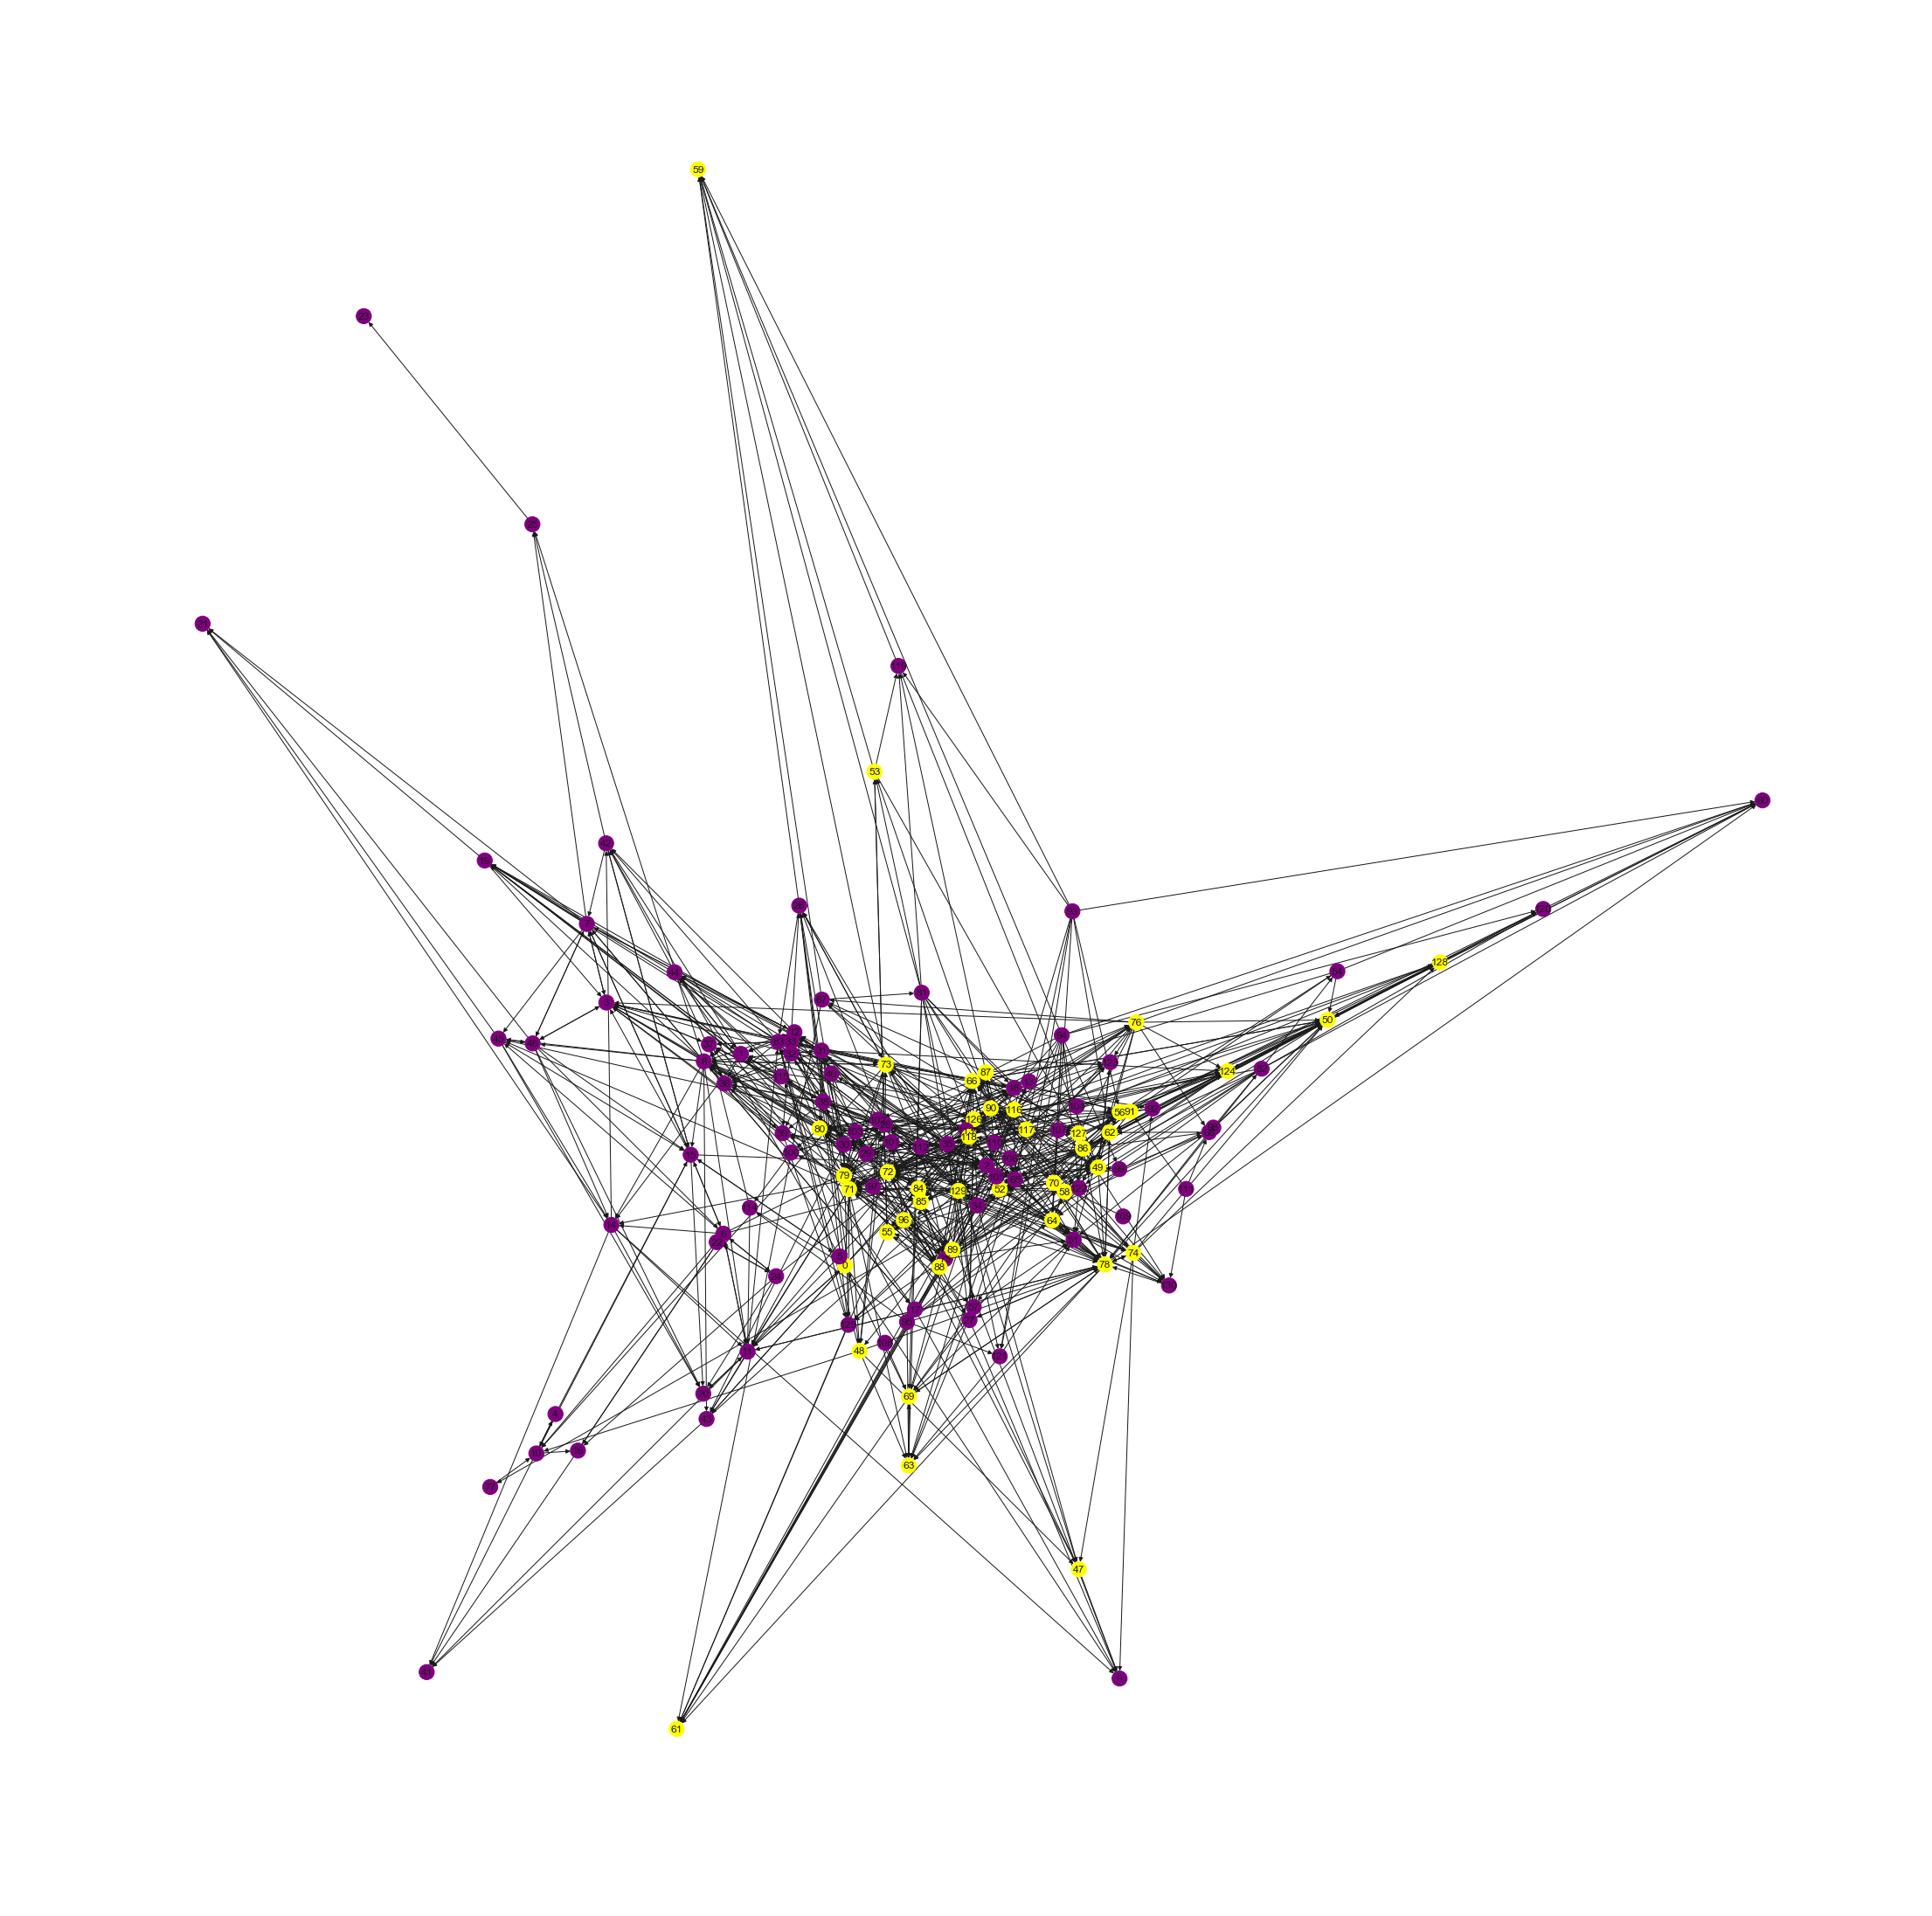

In [40]:
# Plot of C Elegans Neural Network with Higher Order Nodes Highlighted

color_map = []
for node in unweighted_dir_graph_1:
    if node in S_min:
        color_map.append('yellow')
    else: color_map.append('purple')      
nx.draw(unweighted_dir_graph_1, node_color = color_map, with_labels = True)
plt.show()